In [22]:
# Import packages
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import socket 

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [23]:
%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [24]:
con = create_engine(os.getenv('EDM_DATA'))

In [25]:
# Specify latest PLUTO version
pluto = 'dcp_pluto."19v2_w_corrections"'
# Specify previous PLUTO version or the one you want to compare to
plutoprev = 'dcp_pluto."19v2_wo_corrections"'

In [26]:
sql = '''
SELECT  sum(UnitsRes::numeric) as UnitsRes,
        sum(LotArea::numeric) as LotArea,
        sum(BldgArea::numeric) as BldgArea,
        sum(ComArea::numeric) as ComArea,
        sum(ResArea::numeric) as ResArea,
        sum(OfficeArea::numeric) as OfficeArea,
        sum(RetailArea::numeric) as RetailArea,
        sum(GarageArea::numeric) as GarageArea,
        sum(StrgeArea::numeric) as StrgeArea,
        sum(FactryArea::numeric) as FactryArea,
        sum(OtherArea::numeric) as OtherArea,
        sum(AssessLand::numeric) as AssessLand,
        sum(AssessTot::numeric) as AssessTot,
        sum(ExemptTot::numeric) as ExemptTot,
        sum(FIRM07_FLAG::numeric) as FIRM07_FLAG,
        sum(PFIRM15_FLAG::numeric) as PFIRM15_FLAG
FROM {}
'''

In [27]:
df = pd.read_sql(sql=sql.format(pluto), con=con)
df_prev = pd.read_sql(sql=sql.format(plutoprev), con=con)

In [28]:
old = pd.read_csv('https://raw.githubusercontent.com/NYCPlanning/db-pluto-qaqc/master/19v1/19v1-18v2.1-18v1-aggregate_value_comparison.csv', index_col=False)

In [29]:
old = old.iloc[1:-1, 1:]

In [30]:
old = old.drop(['ExemptLand'], axis=1)

In [31]:
old.columns = [i.lower() for i in old.columns]

In [32]:
df['version'] = '19v2_beta'
df_prev['version'] = '19v1'

In [33]:
summary = pd.concat([old, df_prev,df], sort=False)
summary.index = summary.version
summary_pct = summary.iloc[:, 1:].pct_change()

In [34]:
summary

,version,unitsres,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,assessland,assesstot,exempttot,firm07_flag,pfirm15_flag
version,,,,,,,,,,,,,,,,,
18v2.1,18v2.1,3572157.0,6.813542e+09,5.504286e+09,1.820455e+09,3.477582e+09,654410227.0,276896354.0,120942956.0,100257225.0,116612843.0,524200834.0,9.782664e+10,3.936520e+11,1.446245e+11,34683.0,65688.0
19v1,19v1,3586812.0,6.834281e+09,5.653044e+09,1.826711e+09,3.488930e+09,658083538.0,276439866.0,121218485.0,99835648.0,116571445.0,526970235.0,1.065292e+11,4.509298e+11,1.507207e+11,34688.0,65706.0
19v2_beta,19v2_beta,3586812.0,6.953164e+09,5.653044e+09,1.826711e+09,3.488930e+09,658083538.0,276439866.0,121218485.0,99835648.0,116571445.0,526970235.0,1.065292e+11,4.509298e+11,1.507207e+11,34688.0,65706.0


In [35]:
summary_pct

,unitsres,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,assessland,assesstot,exempttot,firm07_flag,pfirm15_flag
version,,,,,,,,,,,,,,,,
18v2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19v1,0.004103,0.003044,0.027026,0.003436,0.003263,0.005613,-0.001649,0.002278,-0.004205,-0.000355,0.005283,0.088959,0.145504,0.042152,0.000144,0.000274
19v2_beta,0.000000,0.017395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


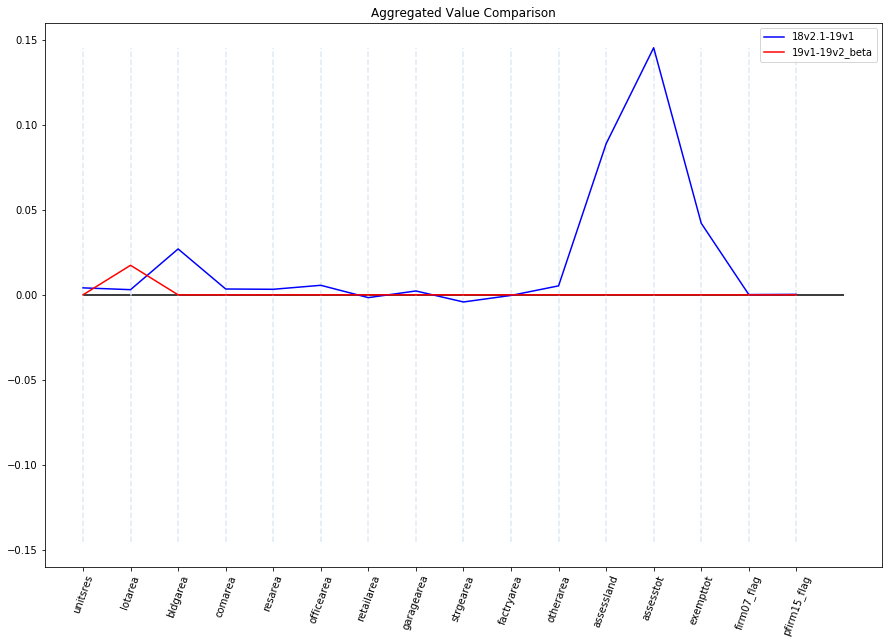

In [36]:
plt.figure(figsize=(15, 10))
plt.plot(range(16), summary_pct.iloc[1, :], color = 'blue', label='18v2.1-19v1')
plt.plot(range(16), summary_pct.iloc[2, :], color = 'red', label='19v1-19v2_beta')
plt.hlines(0, 16, 0) #0 reference line
for i in range(16):
    plt.vlines(i, min(-summary_pct.iloc[1, :]), max(summary_pct.iloc[1, :]), color = '#e1e9f7', linestyles='dashed')
plt.xticks(range(16), summary_pct.columns, rotation=70)
plt.title('Aggregated Value Comparison')
plt.legend()
plt.show()